#KMeans Clustering with TF-IDF Embeddings

In this notebook, we apply KMeans clustering to group Lithuanian news article summaries using TF-IDF vector representations. This approach serves as a benchmark to compare against a more advanced method based on SentenceTransformer embeddings with Agglomerative Clustering.

*Load cleaned summaries generated by our fine-tuned mBART model.
* Convert the text into TF-IDF vectors (term frequency–inverse document frequency).
* Apply KMeans clustering (with a predefined number of clusters, e.g., k=8).
* Evaluate the clustering results using:

Silhouette Score – to measure intra-cluster similarity.

Davies-Bouldin Index – to assess cluster compactness and separation.

* Visualize the resulting clusters using UMAP for dimensionality reduction.
* Extract and display the top keywords for each cluster using the average TF-IDF weights.

This method is computationally cheaper and simpler than transformer-based embeddings but provides a useful baseline for interpreting model effectiveness.

###Installing packages

* umap-learn - for dimensionality reduction and data visualization. Converts high-dimensional data (e.g. 384D) to low-dimensional (e.g. 2D or 3D).

In [ ]:
!pip install umap-learn

###Import modules and functions

* TfidfVectorizer - a tool in the scikit-learn library for converting texts into numerical vectors based on TF-IDF weights
* Kmeans - clustering algorithm
* nltk - to get a list of stop words

###Metrics
Two main metrics will be used to measure the quality of clusterization.

* Silhouette score - measures how well each point is assigned to its cluster compared to other clusters. Result will be between -1 and 1, the closer to 1 the better. For each point, we calculate a – the average distance to other points in its cluster. b – the average distance to points in the nearest other cluster.

* Davies-Bouldin score - Evaluates the density and separation of clusters from each other. The smaller the number the better result

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

###Benchmark with K-means + TF-IDF

* tolist() - TF-IDF vectorizer (TfidfVectorizer) requires an iterable list of texts, not a pandas Series
* lt_stopwords - words that have no semantic value, such as conjunctions ("and", "that", "with"), and are removed from the analysis. This improves the assessment of word significance
* vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words) - creates a TF-IDF vectorizer. max_features Limits the number of words analyzed to 1000 (most frequent) and stop_words throws out irrelevant words
* X_tfidf = vectorizer.fit_transform(texts) - converts texts into numeric vectors using TF-IDF
* n_clusters = 8 - we are dividing texts into 8 groups since there were 8 main categories of 15min.lt news
* n_init="auto" - automatic parameter optimization
* random_state - without random_state, the algorithm could generate different results each time due to random initialization



In [ ]:
df = pd.read_csv("/content/mbart_summary_dataset.csv")
texts = df["Cleaned_for_clustering"].fillna("").tolist()

lt_stopwords = [
    "ir", "kad", "su", "yra", "apie", "kaip", "tačiau", "dėl", "buvo",
    "nuo", "už", "iki", "tarp", "nes", "ar", "kuris", "kur", "kas", "ką",
    "vis", "jo", "jos", "jų", "turi", "būti", "todėl", "nei", "o", "bet",
    "labai", "iš", "po", "ji", "taip", "gali", "tiek", "prieš", "pat", "bei",
    "jis", "savo", "tekste", "per", "bus", "ne", "kai", "tai", "siekiant",
    "pabrėžia", "pabrėžiant", "vyks", "metu", "teigia", "siekia", "dar",
    "siekdama", "tik", "įskaitant", "įskaitant", "kurie"
]

stop_words = lt_stopwords

vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words)
X_tfidf = vectorizer.fit_transform(texts)

n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=2025, n_init="auto")
df["kmeans_cluster"] = kmeans.fit_predict(X_tfidf)

sil_score = silhouette_score(X_tfidf, df["kmeans_cluster"])
db_score = davies_bouldin_score(X_tfidf.toarray(), df["kmeans_cluster"])

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")

df.to_csv("/content/kmeans_clustered.csv", index=False)

#Results of Silhouette score and Davies-Bouldin score

These results show that the quality of KMeans clustering is very limited, especially compared to the transformer-based method.

Silhouette Score = 0.0270 It is a very low value, meaning that the articles are poorly assigned to their own clusters. Moreover they are also close to the centers of other clusters and the clusters overlap, and there are almost no clear boundaries between them.

Davies-Bouldin Index = 5.8270 a lower value is better. 5.83 indicates high cluster overlap and poor separation. The clusters are not compact enough or are very similar to each other.

This confirms that TF-IDF vectorization alone is not sufficient for semantic understanding of text, especially in Lithuanian. It does not process the context of words or their meaning relationships, and therefore the semantic differentiation between articles remains poor.

This benchmark allows us to better assess the advantages of the SentenceTransformer + Agglomerative method, which:

* achieved a twofold better Silhouette Score
* a lower Davies–Bouldin index

image.png

#UMAP Visualization of KMeans Clusters

* UMAP uses the n_neighbors hyperparameter, which controls how many local neighbors for each point will be considered when reducing the dimension
* Lower values ​​(5–15) - more local structures (smaller clusters, detailed contours)
* Higher values ​​(30–50) - more global structure (larger formations)

**25 chosen as a balance between detailed locality and maintaining the overall structure**

* min_dist=0.3 - sets the minimum distance between points in low dimension
* metric="cosine" - calculates the distance between insertions based on cosine similarity (optimal for texts)
* random_state=2025 - the UMAP algorithm uses random initialization to begin optimizing the placement of points in low dimension. Without random_state: Each run can yield different coordinates, even using the same data and parameters
* tfidf_matrix.toarray() - converts a sparse matrix to a dense array so that UMAP can process it
* df["umap_1_kmeans"] = umap_embeddings_kmeans[:, 0] and df["umap_2_kmeans"] = umap_embeddings_kmeans[:, 1] - each line contains 2D coordinates (UMAP projection) — they will be used in the drawing



In [ ]:
import umap
import matplotlib.pyplot as plt


vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(df["mbart_summary"])

kmeans = KMeans(n_clusters=8, random_state=2025)
df["kmeans_cluster"] = kmeans.fit_predict(tfidf_matrix)

umap_model_kmeans = umap.UMAP(n_neighbors=25, min_dist=0.3, metric="cosine", random_state=2025)
umap_embeddings_kmeans = umap_model_kmeans.fit_transform(tfidf_matrix.toarray())

df["umap_1_kmeans"] = umap_embeddings_kmeans[:, 0]
df["umap_2_kmeans"] = umap_embeddings_kmeans[:, 1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["umap_1_kmeans"],
    df["umap_2_kmeans"],
    c=df["kmeans_cluster"],
    cmap="tab10",
    alpha=0.7
)
plt.colorbar(scatter, label="KMeans Klasteriai")
plt.title("UMAP Visualizatiob – TF-IDF + KMeans")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

###Results of visualization with UMAP

The UMAP map with KMeans clustering using TF-IDF shows that the clusters are visually poorly separated, which is also consistent with the metrics presented above:
* Most of the points overlap, the colors (clusters) have almost no clear boundaries.
* There are no compact “islands” or clearly separated regions.
* The only one that stands out a bit more is the orange cluster (1), but even it overlaps with the others.

Silhouette Score = 0.0270 | Davies-Bouldin Index = 5.8270
The map only confirms that the clustering was weak:
* TF-IDF does not capture context (e.g. synonyms or semantic relations).
* KMeans creates round, even clusters that fail to capture natural linguistic structures.

This visualization demonstrates that clustering based on semantic context (transformer embeddings) is significantly more efficient than the traditional bag-of-words (TF-IDF) method, which fails to capture semantic relationships, making the clusters semantically meaningless.

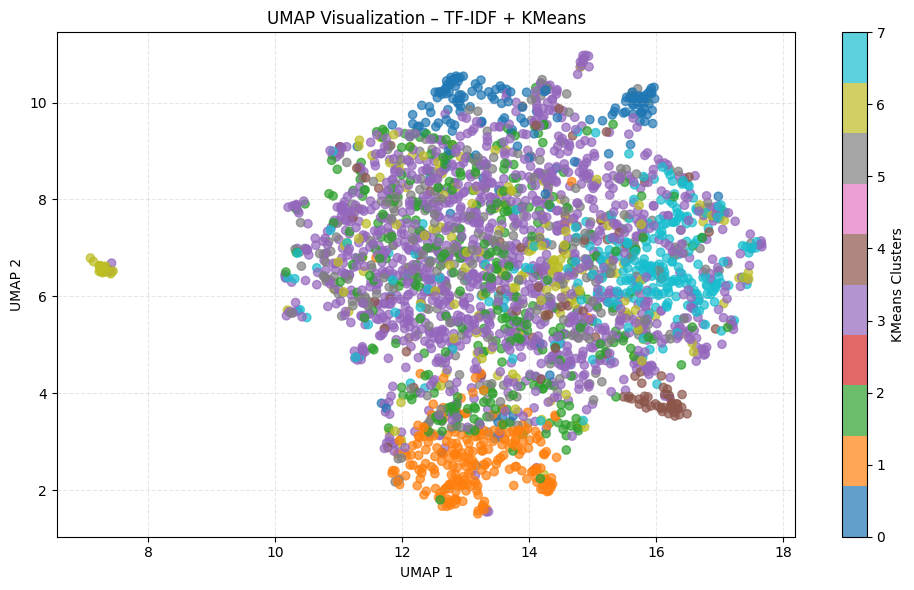

###TOP words in eatch cluster

We will use TF-IDF (Term Frequency–Inverse Document Frequency) method to analyze the text set of each cluster and extract the most important words — this helps to describe the clusters semantically. The main intent is to find the most common, but also informative words in each cluster using the mbart_summary field. TF: How often does the word occur in the text. IDF: How rare is the word in all texts.

* clusters = sorted(dataframe[cluster_column].unique()) - goes through all clusters
cluster_texts = dataframe[dataframe[cluster_column] == cluster_id][text_column].fillna("").tolist() - filters texts for each cluster
* tfidf = TfidfVectorizer(stop_words=lt_stopwords, max_features=1000) - creates a TF-IDF vectorizer. max_features Limits the number of words analyzed to 1000 (most frequent) and stop_words throws out irrelevant words
* tfidf_matrix = tfidf.fit_transform(cluster_texts) - processes the cluster texts and converts them into a numerical TF-IDF matrix that reflects the importance of each word in each text
* scores = tfidf_matrix.sum(axis=0).A1 - Counts the total value of each word in the cluster. Since sum(axis=0) returns a 2D matrix, A1 is a way to convert a numpy matrix object to a 1D numpy array to make it easier to work with the values
* words = tfidf.get_feature_names_out() - returns the dictionary (all unique words) that TfidfVectorizer learned from the cluster texts. Each word corresponds to one column in the tfidf_matrix matrix
* sorted_indices = scores.argsort()[::-1][:n_top_words] - Sorts by importance and takes the TOP n
* top_words_list.append({"cluster": cluster_id, "top_words": ", ".join(top_words)}) - adds to the result list

In [ ]:
df = pd.read_csv("/content/kmeans_clustered.csv")

lt_stopwords = lt_stopwords

def get_top_words_per_cluster(dataframe, text_column, cluster_column, n_top_words=10):
    clusters = sorted(dataframe[cluster_column].unique())
    top_words_list = []

    for cluster_id in clusters:
        cluster_texts = dataframe[dataframe[cluster_column] == cluster_id][text_column].fillna("").tolist()
        tfidf = TfidfVectorizer(
            stop_words=lt_stopwords,
            max_features=1000
        )
        tfidf_matrix = tfidf.fit_transform(cluster_texts)
        scores = tfidf_matrix.sum(axis=0).A1
        words = tfidf.get_feature_names_out()
        sorted_indices = scores.argsort()[::-1][:n_top_words]
        top_words = [words[i] for i in sorted_indices]
        top_words_list.append({"cluster": cluster_id, "top_words": ", ".join(top_words)})

    return pd.DataFrame(top_words_list)

top_words_df = get_top_words_per_cluster(df, "mbart_summary", "kmeans_cluster", n_top_words=10)
top_words_df.to_csv("/content/top_words_per_cluster_kmeans.csv", index=False)

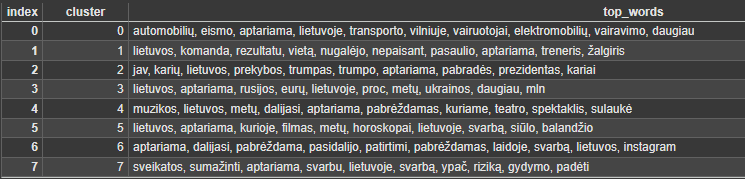